In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


<h1><font size="6">Cataract Classification</font></h1>

In this notebook, uses two retina datasets to challenge the cataract classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Build the model(1)](#build1)
* [Build the model(2)](#build2)

## Import libraries <a name="import"> </a>

In [2]:
%pip install -q efficientnet >> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import *
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

2023-12-08 13:58:17.047848: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 13:58:19.095331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 13:58:19.095621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 13:58:19.443432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 13:58:20.245467: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 13:58:20.251073: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
# /kaggle/input/cataractdataset
self_collected = r'EyeDataset'

##Online dataset
r1 = 'KaggleDataset/processed_images/test/'
r2 = r'KaggleDataset/processed_images/train/'


## Set configurations and read metadata <a name="set"> </a>

In [5]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256


In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Loading the Dataset

In [7]:
n = 0
c = 0
path_list=[]
for types in os.listdir(self_collected):
    if 'Normal' in types:
        for files in os.listdir(os.path.join(self_collected,types)):
            n+=1
            path_list.append(os.path.join(self_collected,types,files))
    elif "catarct" in types:
        for files in os.listdir(os.path.join(self_collected,types)):
            c+=1
            path_list.append(os.path.join(self_collected,types,files))

labels = np.zeros(n,dtype=np.int32).tolist() + np.ones(c,dtype=np.int32).tolist()
new_data_df = pd.DataFrame({'paths':path_list,'cataract':labels})






filepaths = glob.glob(r1 + '*/*')

n = 0
c = 0
path_list = []
for file in filepaths:
    if 'normal' in file:
      n+=1
    else:
        c+=1
    path_list.append(file)
    
labels = np.zeros(n,dtype=np.int32).tolist() + np.ones(c,dtype=np.int32).tolist()
new_data_df1 = pd.DataFrame({'paths':path_list,'cataract':labels})



filepaths = glob.glob(r2 + '*/*')

n = 0
c = 0
path_list = []
for file in filepaths:
    if 'normal' in file:
      n+=1
    else:
        c+=1
    path_list.append(file)

#for types in os.listdir(r2):hollywood movie with chaiyya chaiyya
#    if 'normal' in files:
#        for files in os.listdir(os.path.join(r2,types)):
#            n+=1
#            path_list.append(os.path.join(r2, types, files))
#    elif "cataract" in types:
#        for files in os.listdir(os.path.join(r2,types)):
#            c+=1
#            path_list.append(os.path.join(r2, types, files))


labels = np.zeros(n,dtype=np.int32).tolist() + np.ones(c,dtype=np.int32).tolist()
new_data_df2 = pd.DataFrame({'paths':path_list,'cataract':labels})

In [8]:
cat_df = pd.concat([new_data_df,new_data_df1, new_data_df2 ],axis=0,ignore_index=True)
cat_df

,paths,cataract
0,EyeDataset/Normal/79.jpg,0
1,EyeDataset/Normal/76.jpg,0
2,EyeDataset/Normal/104.jpg,0
3,EyeDataset/Normal/52.jpg,0
4,EyeDataset/Normal/33.jpg,0
...,...,...
832,KaggleDataset/processed_images/train/normal/im...,1
833,KaggleDataset/processed_images/train/normal/im...,1
834,KaggleDataset/processed_images/train/normal/im...,1
835,KaggleDataset/processed_images/train/normal/im...,1


In [9]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
cataract
1    425
0    412
Name: count, dtype: int64


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [10]:
df = cat_df
df

,paths,cataract
0,EyeDataset/Normal/79.jpg,0
1,EyeDataset/Normal/76.jpg,0
2,EyeDataset/Normal/104.jpg,0
3,EyeDataset/Normal/52.jpg,0
4,EyeDataset/Normal/33.jpg,0
...,...,...
832,KaggleDataset/processed_images/train/normal/im...,1
833,KaggleDataset/processed_images/train/normal/im...,1
834,KaggleDataset/processed_images/train/normal/im...,1
835,KaggleDataset/processed_images/train/normal/im...,1


In [11]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [12]:
train_df.shape, test_df.shape, val_df.shape

((568, 2), (168, 2), (101, 2))

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'cataract' column contains labels as 0 for 'normal' and 1 for 'cataract'
train_counts = train_df['cataract'].value_counts()
test_counts = test_df['cataract'].value_counts()
val_counts = val_df['cataract'].value_counts()

# Define colors for the bars
colors = ['blue', 'red']

# Create sub-plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot histograms
axs[0].bar(train_counts.index, train_counts.values, color=colors)
axs[0].set_title('Training set')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Normal', 'Cataract'])

# Add numbers on top of the bars
for i, count in enumerate(train_counts.values):
    axs[0].text(i, count + 1, str(count), ha='center', va='bottom')

axs[1].bar(test_counts.index, test_counts.values, color=colors)
axs[1].set_title('Test set')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Normal', 'Cataract'])

# Add numbers on top of the bars
for i, count in enumerate(test_counts.values):
    axs[1].text(i, count + 1, str(count), ha='center', va='bottom')

axs[2].bar(val_counts.index, val_counts.values, color=colors)
axs[2].set_title('Validation set')
axs[2].set_xticks([0, 1])
axs[2].set_xticklabels(['Normal', 'Cataract'])

# Add numbers on top of the bars
for i, count in enumerate(val_counts.values):
    axs[2].text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

In [ ]:
train_imgs.shape

In [ ]:
train_df

In [ ]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

In [ ]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

# Shallow CNN

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='tanh'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='tanh'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df) 

In [ ]:
# from tensorflow import 
model.save('my_model.h5')

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
)

In [ ]:
np.argmax(test_df.values)

In [ ]:
y_true , y_pred = np.argmax(test_df.values,axis=1), np.argmax(model.predict(test_imgs), axis=1)

In [ ]:
test_df.shape

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Specificity or true negative rate
    specificity = tn / (tn+fp)
    print(f'Specificity: {specificity}')

    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = tp / (tp+fn)
    print(f'Sensitivity (Recall): {sensitivity}')

    # Precision or positive predictive value
    precision = precision_score(y_true, y_pred)
    print(f'Precision: {precision}')

    # F1 score
    f1 = f1_score(y_true, y_pred)
    print(f'F1 Score: {f1}')
calculate_metrics(y_true, y_pred)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

    # Labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
y_pred = np.argmax(model.predict(test_imgs), axis=1)
y_pred

In [ ]:
y_true = np.argmax(test_df.values,axis=1)
y_true

In [ ]:
def count_correct_predictions(y_pred, y_true):
    correct_count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            correct_count += 1
    return correct_count

correct_predictions = count_correct_predictions(y_pred, y_true)
print("Number of correct predictions:", correct_predictions)

In [ ]:
test_imgs.shape[0]

In [ ]:
def find_incorrect_class_1_indexes(y_pred, y_true):
    incorrect_indexes = []
    for i in range(len(y_pred)):
        if y_true[i] == 0 and y_pred[i] == 0:
            incorrect_indexes.append(i)
    return incorrect_indexes

a = find_incorrect_class_1_indexes(y_pred,y_true)
a

In [ ]:
wrong = test_imgs[a]

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
for i, img in enumerate(wrong):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df)

## Deep CNN

In [ ]:
IMG_HEIGHT = 192
IMG_WIDTH = 256
test_image_path = "/kaggle/input/testdata/c5.jpeg"
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
imge = np.expand_dims(img, axis=0)
ans = model.predict(imge)
ans

In [ ]:
np.argmax(ans)

# Cataract Net


In [ ]:
model2 = Sequential()
model2.add(Conv2D(32,kernel_size=3,padding='valid',input_shape=input_shape,activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(32,kernel_size=3,padding='valid',input_shape=input_shape,activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(64,kernel_size=3,padding='valid',input_shape=input_shape,activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(128,kernel_size=3,padding='valid',input_shape=input_shape,activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Epoch 1/100
17/17 [==============================] - 18s 788ms/step - loss: 0.6968 - accuracy: 0.4736 - val_loss: 0.6929 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 13s 706ms/step - loss: 0.6936 - accuracy: 0.4701 - val_loss: 0.6929 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 14s 762ms/step - loss: 0.6935 - accuracy: 0.4930 - val_loss: 0.6927 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 15s 827ms/step - loss: 0.6933 - accuracy: 0.5282 - val_loss: 0.6910 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 15s 812ms/step - loss: 0.6878 - accuracy: 0.5563 - val_loss: 0.6861 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 14s 785ms/step - loss: 0.6849 - accuracy: 0.5757 - val_loss: 0.6871 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 14s 7

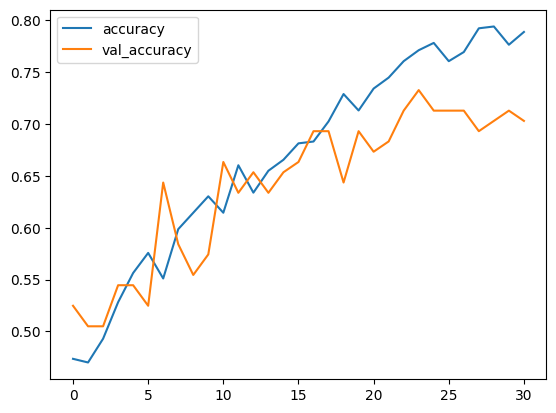

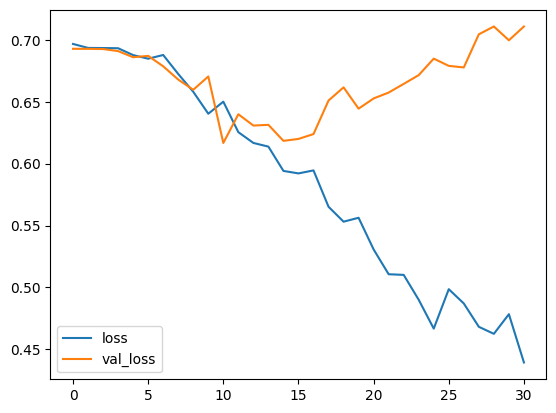

In [51]:
history = model2.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [52]:
model2.evaluate(test_imgs, test_df) 

6/6 [==============================] - 1s 96ms/step - loss: 0.7005 - accuracy: 0.6667


[0.700516402721405, 0.6666666865348816]

In [57]:
y_true , y_pred = np.argmax(test_df.values,axis=1), np.argmax(model2.predict(test_imgs), axis=1)
plot_confusion_matrix(y_true, y_pred)

NameError: name 'model2' is not defined

In [54]:
calculate_metrics(y_true, y_pred)

Specificity: 0.5180722891566265
Sensitivity (Recall): 0.8117647058823529
Precision: 0.6330275229357798
F1 Score: 0.711340206185567


In [55]:
tf.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [56]:
model2.save('cataract_net.h5')

/home/saint/Desktop/FYP/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Build the model(2) <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [40]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
#     num_layers = len(base_model.layers)

#     for layer in base_model.layers[:num_layers // 2]:
#         layer.trainable = False
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 efficientnet-b0 (Functiona  (None, 6, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4052126 (15.46 MB)
Trainable params: 4010110 (15.30 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [41]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
17/17 [==============================] - 63s 3s/step - loss: 0.7311 - accuracy: 0.5194 - val_loss: 0.7802 - val_accuracy: 0.4752 - lr: 3.0000e-06
Epoch 2/100
17/17 [==============================] - 50s 3s/step - loss: 0.7316 - accuracy: 0.5176 - val_loss: 0.7381 - val_accuracy: 0.4851 - lr: 3.0000e-06
Epoch 3/100
17/17 [==============================] - 51s 3s/step - loss: 0.7104 - accuracy: 0.5317 - val_loss: 0.7097 - val_accuracy: 0.5149 - lr: 3.0000e-06
Epoch 4/100
17/17 [==============================] - 51s 3s/step - loss: 0.6936 - accuracy: 0.5880 - val_loss: 0.6924 - val_accuracy: 0.5842 - lr: 3.0000e-06
Epoch 5/100
17/17 [==============================] - 49s 3s/step - loss: 0.6714 - accuracy: 0.6285 - val_loss: 0.6755 - val_accuracy: 0.5941 - lr: 3.0000e-06
Epoch 6/100
17/17 [==============================] - 51s 3s/step - loss: 0.6675 - accuracy: 0.6408 - val_loss: 0.6620 - val_accuracy: 0.6238 - lr: 3.0000e-06
Epoch 7/100
17/17 [==============================] -

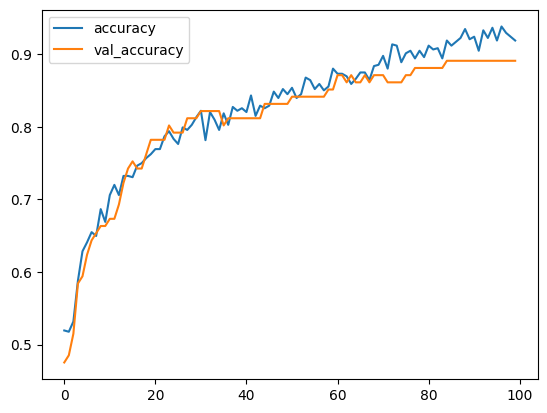

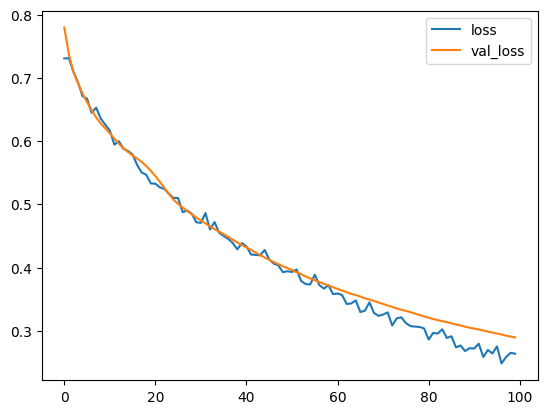

In [42]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [55]:
model.evaluate(test_imgs, test_df) 

6/6 [==============================] - 14s 2s/step - loss: 0.7088 - accuracy: 0.7500


[0.7087810039520264, 0.75]

6/6 [==============================] - 14s 2s/step


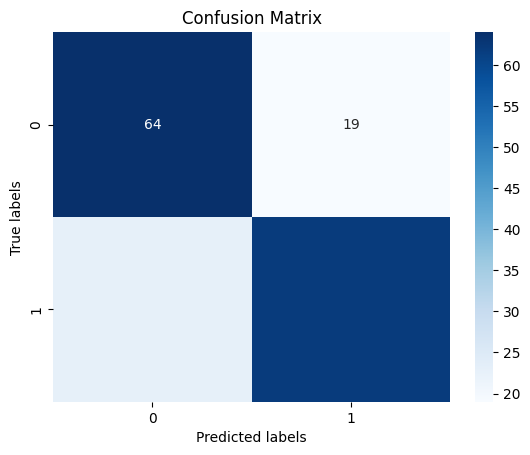

In [56]:
y_true , y_pred = np.argmax(test_df.values,axis=1), np.argmax(model.predict(test_imgs), axis=1)
plot_confusion_matrix(y_true, y_pred)

In [45]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
calculate_metrics(y_true, y_pred)

Specificity: 0.7590361445783133
Sensitivity (Recall): 0.8941176470588236
Precision: 0.7916666666666666
F1 Score: 0.839779005524862


In [47]:
model.save('eff_net.h5')

/home/saint/Desktop/FYP/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('your_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpo92asibs/assets


INFO:tensorflow:Assets written to: /tmp/tmpo92asibs/assets
2023-12-08 15:36:57.639647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-08 15:36:57.639779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-08 15:36:57.673392: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo92asibs
2023-12-08 15:36:57.733707: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-08 15:36:57.733742: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpo92asibs
2023-12-08 15:36:57.814676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-08 15:36:57.859655: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-08 15:36:59.088400: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [49]:
print('helo')

helo


In [50]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50

def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_imgs[0].shape)
#     base_model.trainable = False 
## Not trainable weights

    num_layers = len(base_model.layers)

    for layer in base_model.layers[:num_layers // 2]:
        layer.trainable = False
    x = base_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 13570306 (51.77 MB)
Non-trainable params: 1145408 (4.37 MB)
_________________________________________________________________


Epoch 1/100
17/17 [==============================] - 126s 7s/step - loss: 0.7014 - accuracy: 0.5546 - val_loss: 0.5951 - val_accuracy: 0.6634 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - 136s 8s/step - loss: 0.5933 - accuracy: 0.6655 - val_loss: 0.5437 - val_accuracy: 0.7327 - lr: 1.0000e-04
Epoch 3/100
17/17 [==============================] - 136s 8s/step - loss: 0.5478 - accuracy: 0.7095 - val_loss: 0.4937 - val_accuracy: 0.7525 - lr: 1.0000e-04
Epoch 4/100
17/17 [==============================] - 138s 8s/step - loss: 0.5433 - accuracy: 0.7306 - val_loss: 0.7251 - val_accuracy: 0.6436 - lr: 1.0000e-04
Epoch 5/100
17/17 [==============================] - 137s 8s/step - loss: 0.6084 - accuracy: 0.6690 - val_loss: 0.4968 - val_accuracy: 0.7228 - lr: 1.0000e-04
Epoch 6/100
17/17 [==============================] - 136s 8s/step - loss: 0.5148 - accuracy: 0.7518 - val_loss: 0.4789 - val_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 7/100
17/17 [===========================

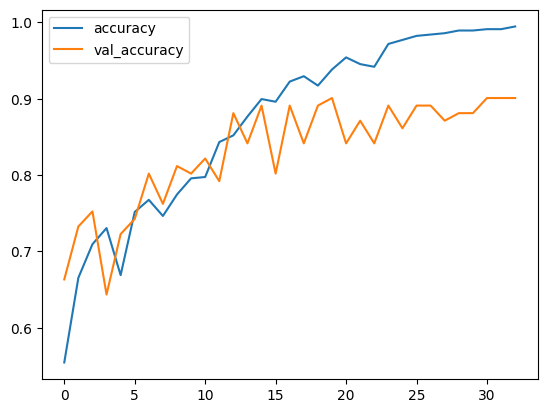

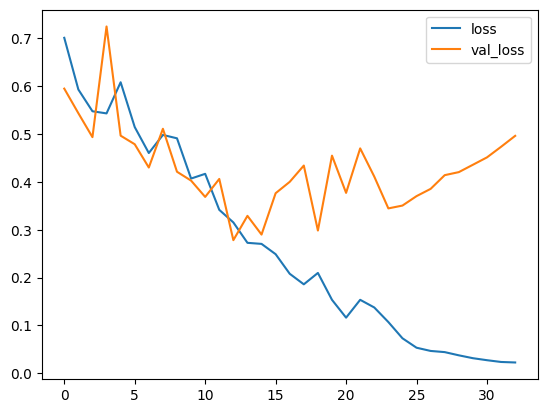

In [51]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [52]:
model.evaluate(test_imgs, test_df)

6/6 [==============================] - 15s 2s/step - loss: 0.7088 - accuracy: 0.7500


[0.7087810039520264, 0.75]

In [53]:
train  = [92,96,97]
valid = [76,92,93]
test = [70.8,85,94]

In [54]:
import pandas as pd

data = {
    'Model': ['Shallow CNN', 'Deep CNN (CataractNet)', 'EfficientNet'],
    'Training Accuracy (%)': [92, 96, 97],
    'Validation Accuracy (%)': [76, 92, 93],
    'Test Accuracy (%)': [70.8, 85, 94]
}

df = pd.DataFrame(data)
df

,Model,Training Accuracy (%),Validation Accuracy (%),Test Accuracy (%)
0,Shallow CNN,92,76,70.8
1,Deep CNN (CataractNet),96,92,85.0
2,EfficientNet,97,93,94.0
